In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

In [ ]:
# Загрузка данных
data = pd.read_csv('loan_approval_dataset.csv')

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
# Удалите пробелы и приведите к нижнему регистру
data['education'] = data['education'].str.strip().str.lower()
data['self_employed'] = data['self_employed'].str.strip().str.lower()
data['loan_status'] = data['loan_status'].str.strip().str.lower()

In [ ]:
# Преобразование категориальных переменных
data['education'] = data['education'].map({'graduate': 1, 'not graduate': 0})
data['self_employed'] = data['self_employed'].map({'yes': 1, 'no': 0})
data['loan_status'] = data['loan_status'].map({'approved': 1, 'rejected': 0})

# Отделение целевой переменной
X = data.drop(['loan_id', 'loan_status'], axis=1)
y = data['loan_status']

# Стандартизация данных
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [ ]:
class CreditApprovalNet(nn.Module):
    def __init__(self):
        super(CreditApprovalNet, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [ ]:
# Инициализация модели, функции потерь и оптимизатора
model = CreditApprovalNet()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Обучение модели ===
num_epochs = 50
batch_size = 16
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        # Обнуление градиентов
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(batch_X)

        # Вычисление функции потерь
        loss = criterion(outputs, batch_y)

        # Обратное распространение
        loss.backward()

        # Обновление параметров
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 0.3791
Epoch [2/50], Loss: 0.0782
Epoch [3/50], Loss: 0.2928
Epoch [4/50], Loss: 0.1777
Epoch [5/50], Loss: 0.0807
Epoch [6/50], Loss: 0.0324
Epoch [7/50], Loss: 0.0178
Epoch [8/50], Loss: 0.2614
Epoch [9/50], Loss: 0.1516
Epoch [10/50], Loss: 0.2120
Epoch [11/50], Loss: 0.2310
Epoch [12/50], Loss: 0.2361
Epoch [13/50], Loss: 0.0153
Epoch [14/50], Loss: 0.0993
Epoch [15/50], Loss: 0.0178
Epoch [16/50], Loss: 0.0411
Epoch [17/50], Loss: 0.0236
Epoch [18/50], Loss: 0.2304
Epoch [19/50], Loss: 0.0009
Epoch [20/50], Loss: 0.0292
Epoch [21/50], Loss: 0.0103
Epoch [22/50], Loss: 0.0900
Epoch [23/50], Loss: 0.1846
Epoch [24/50], Loss: 0.1034
Epoch [25/50], Loss: 0.0155
Epoch [26/50], Loss: 0.0084
Epoch [27/50], Loss: 0.0301
Epoch [28/50], Loss: 0.3318
Epoch [29/50], Loss: 0.0021
Epoch [30/50], Loss: 0.1158
Epoch [31/50], Loss: 0.0039
Epoch [32/50], Loss: 0.0783
Epoch [33/50], Loss: 0.1555
Epoch [34/50], Loss: 0.0423
Epoch [35/50], Loss: 0.1349
Epoch [36/50], Loss: 0.1218
E

In [ ]:
# Прогнозы на тестовых данных
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)

# Метрики
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       323
           1       0.98      0.98      0.98       531

    accuracy                           0.97       854
   macro avg       0.97      0.97      0.97       854
weighted avg       0.97      0.97      0.97       854

Confusion Matrix:
[[310  13]
 [ 13 518]]


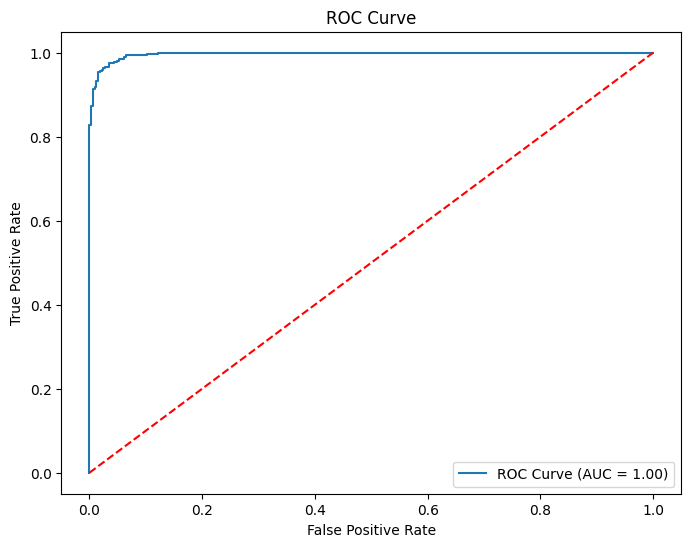

In [ ]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

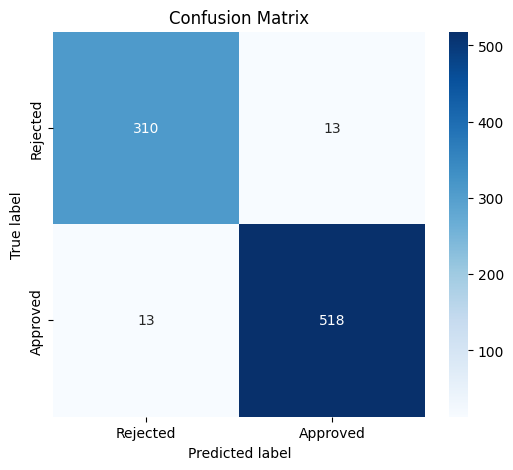

In [ ]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# Сохранение модели
torch.save(model.state_dict(), 'credit_approval_net.pth')

In [ ]:
#Загрузка модели и предсказание на новых данных
model = CreditApprovalNet()
model.load_state_dict(torch.load('credit_approval_net.pth'))
model.eval()

In [ ]:
# Пример пользовательских данных
custom_data = {
    'no_of_dependents': [3],
    'education': [1],
    'self_employed': [0],
    'income_annum': [7000000],
    'loan_amount': [20000000],
    'loan_term': [15],
    'cibil_score': [750],
    'residential_assets_value': [5000000],
    'commercial_assets_value': [3000000],
    'luxury_assets_value': [15000000],
    'bank_asset_value': [8000000]
}

custom_data_df = pd.DataFrame(custom_data)
custom_data_scaled = scaler.transform(custom_data_df)
custom_data_tensor = torch.tensor(custom_data_scaled, dtype=torch.float32)

# Предсказание
with torch.no_grad():
    custom_prediction_prob = model(custom_data_tensor).item()
    custom_prediction = 1 if custom_prediction_prob >= 0.5 else 0

status = 'Одобрено' if custom_prediction == 1 else 'Отклонено'
print(f"Результат предсказания для пользовательских данных: {status}")
print(f"Вероятность: {custom_prediction_prob:.2f} для одобрения")